# Style Classifier
Let's predict style from ingredients.
This notebook depends on: 
* `recipe_vecs.h5`, which is generated by `recipe2vec.py`
* `all_recipes.h5`, which is generated by `converter.py`

In [135]:
import pandas as pd
import numpy as np
import imblearn
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score

# Import data

In [2]:
with pd.HDFStore('recipe_vecs.h5', 'r') as store:
    recipe_vecs = store.get('vecs')

In [3]:
with pd.HDFStore('all_recipes.h5', 'r') as store:
    recipe_catalog = store.get('core')
    recipe_catalog = recipe_catalog.loc[recipe_vecs.index]

# Simple modelling challenge: is the beer an IPA? 
## New target feature: is_ipa
* 1 if the style is American IPA
* 0 if not

In [6]:
recipe_catalog['is_ipa'] = (recipe_catalog.style_name == 'american ipa').astype(int)

## Resample to balance the dataset betwen IPAs, non-IPAs

### Use the imblearn model

How unbalanced is it to start?

In [127]:
y = recipe_catalog['is_ipa']
X = recipe_vecs.copy()

In [70]:
scaler = RobustScaler()

In [128]:
X = scaler.fit_transform(X)

In [73]:
# Plot the balance of the data
def plot_balance(y):
    """Display a barchart that shows how balanced the dataset is w.r.t. the target variable"""
    y.value_counts().plot(kind='bar', title='Balance of target variable')

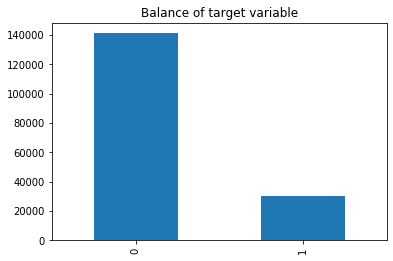

In [74]:
plot_balance(y)

Let's visualize the two classes by doing PCA to bring the data to two dimensions

In [129]:
rus = RandomUnderSampler()

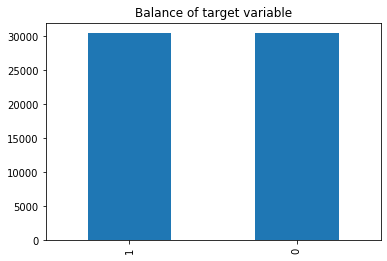

In [130]:
X_rus, y_rus = rus.fit_sample(X, y)
plot_balance(y_rus)

### Do a logistic regression

In [131]:
x_train, x_test, y_train, y_test = train_test_split(X_rus, y_rus)

In [132]:
lr = LogisticRegression(max_iter=1000)

In [133]:
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [136]:
y_pred = lr.predict(x_test)

In [134]:
lr.score(x_test, y_test)

0.7049438644869017

In [137]:
f1_score(y_test, y_pred)

0.7425821972734563

How IPA-y does it think our recipes are?

In [140]:
Y_full_pred = lr.predict(X)

In [141]:
recipe_catalog['is_ipa_prediction'] = Y_full_pred

In [154]:
style_ipa_ness = recipe_catalog.groupby('style_name')['is_ipa_prediction'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

In [156]:
style_ipa_ness = style_ipa_ness[style_ipa_ness['count'] >= 100]

In [158]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(style_ipa_ness)

                                                    mean  count
style_name                                                     
american ipa                                    0.857556  30461
imperial ipa                                    0.840766   7781
american pale ale                               0.817964  24671
american amber ale                              0.755992   5799
blonde ale                                      0.706216   3700
american barleywine                             0.683812   1322
cream ale                                       0.675763   2162
american brown ale                              0.616438   4234
american light lager                            0.564626    147
specialty beer                                  0.521567  11383
american stout                                  0.508228   3160
russian imperial stout                          0.459162   3269
american wheat or rye beer                      0.454852   4740
california common beer                  

# One hot encode categorical labels: style categories

In [222]:
le = LabelEncoder()

In [223]:
encoded_values = le.fit_transform(recipe_catalog_select.style_name.values)
encoded_values = encoded_values.reshape(len(encoded_values), 1)
encoded_values

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [224]:
ohe = OneHotEncoder()

In [225]:
ohe_labels = ohe.fit_transform(encoded_values)
ohe_labels

<34353x2 sparse matrix of type '<class 'numpy.float64'>'
	with 34353 stored elements in Compressed Sparse Row format>

# Scale inputs, fit to labels

In [206]:
scaler = RobustScaler()

In [207]:
scaler.fit(recipe_vecs_select.values)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [208]:
X = scaler.transform(recipe_vecs_select.values)
X

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.70238095e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.16415889e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [6.64408860e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.87742032e+01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.00000000e+01],
       [1.77557540e+00, 0.00000000e+00, 6.65373064e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [246]:
Y = ohe_labels.toarray()

In [238]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)

In [239]:
lr = LinearRegression()

In [240]:
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [241]:
y_pred = lr.predict(x_test)

# Evaluate the model

In [242]:
r2_score(y_test, y_pred)

-207.1271140806192

In [243]:
mean_squared_error(y_test, y_pred)

20.5494817161023